In [4]:
import h5py as hp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import illustris_python as il
import matplotlib.gridspec as gspec
import matplotlib as mpl
import copy
from hc_lib.plots.fig_lib import FigureLibrary
tngpath = '/lustre/cosinga/L75n1820TNG/'
basepath = '/lustre/cosinga/hcolor/fig_md_analysis/'

In [5]:
def get_match(props):
    keys = fsr.keys()
    matches = []
    for k in keys:
        is_match = True
        if 'x' in k:
            for p,v in props.items():
                try:
                    lval = fsr[k].attrs[p]
                    
                    is_match = (is_match and v in lval)
                except KeyError:
                    continue
            if is_match:
                matches.append(k)
    return matches

In [6]:
fsr = hp.File(basepath+'HIXgalaxy/HIxGal_fieldnameR_spaceC_redshift.hdf5', 'r')
rfc = hp.File(basepath+'HIXgalaxy/HIxGal_redshiftR_fieldnameC_color.hdf5', 'r')
head = il.groupcat.loadHeader(tngpath+'output/', 99)


In [7]:
fnlabels = ['D18-Particle, Real Space', 'D18-Particle, Redshift Space', 'D18-Subhalo, Redshift Space']
fnvnlabels = ['HI Particle, Real Space', 'HI Particle, Redshift Space', 'D18-Subhalo, Redshift Space']
fnvnshort = ['$\\rho_{HI}^r(\overrightarrow{x_{\mathrm{ptl}}})$', 
            '$\\rho_{HI}^s(\overrightarrow{x_{\mathrm{ptl}}})$',
            '$\\rho_{D18}^s(\overrightarrow{x_{\mathrm{gal}}})$']
fnshort = ['$\\rho_{D18}^r(\overrightarrow{x_{\mathrm{ptl}}})$', 
            '$\\rho_{D18}^s(\overrightarrow{x_{\mathrm{ptl}}}$',
            '$\\rho_{D18}^s(\overrightarrow{x_{\mathrm{gal}}})$']
rslabels = ['z=0', 'z=0.5', 'z=1', 'z=1.5']

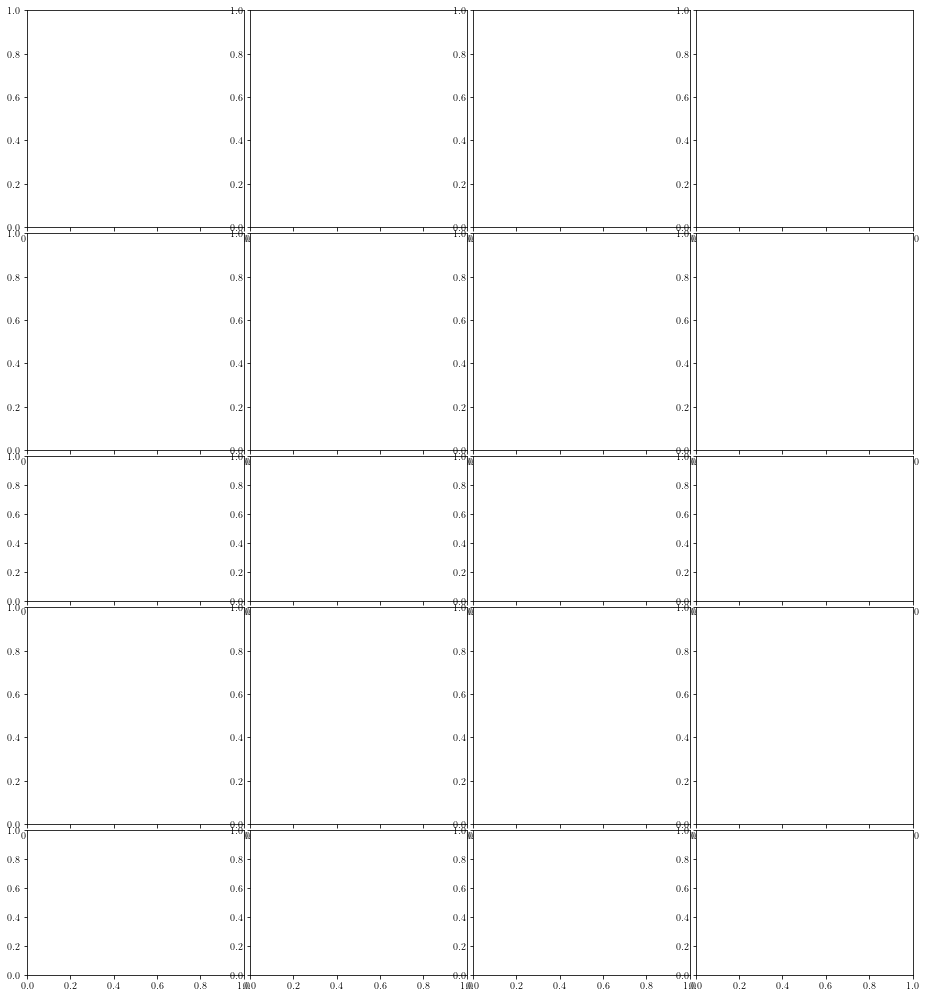

In [16]:
# Now with vn
nrows = 5
ncols = 4
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3
dist_panel_length = 2
ndistpanels = 2

# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * 3 + ndistpanels * dist_panel_length + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols, left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight,
        height_ratios = [3,3,2,3,2])

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.has_cbar_panel = False
flib.figsize = [figwidth, figheight]

In [17]:
keys_for_panels = np.empty((nrows,ncols), dtype=object)

z0 = fsr['0 0 0 x'].attrs['redshift']
fieldnames = ['hiptl','hiptl','hiptl','hisubhalo','hisubhalo']
spaces = ['real', 'redshift','redshift', 'redshift', 'redshift']
# CHANGE WHEN MORE REDSHIFTS ARE CALCULATED
redshifts = [z0, z0, z0, z0]
for i in range(nrows):
    for j in range(ncols):
        props = {'fieldname':fieldnames[i], 'space':spaces[i], 'redshift':redshifts[j]}
        keys_for_panels[i,j] = get_match(props)
        if fieldnames[i] == 'hiptl':
            vnprops = copy.copy(props)
            vnprops['fieldname'] = 'vn'
            keys_for_panels[i,j].extend(get_match(vnprops))


In [18]:
dist_rows = [2,4]
for i in range(nrows):
    for j in range(ncols):
        
            
        idx = (i, j)
        keys = keys_for_panels[idx]
        
        if i in dist_rows:
            ax = flib.panels[i][j]
            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
                real_data = get_match(props)
                rd = real_data[0]
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'red' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
#             mn = np.min(plot_dist, axis=0)
#             mx = np.max(plot_dist, axis=0)
            flib.plotFillPanel(idx, plot_wn, plot_dist, color='red')
            ax.plot([plot_wn[0], plot_wn[-1]],[1,1], color='lightgray', linestyle='--')
            #ax.set_ylim(0, np.max(plot_dist[:,0]))
            
            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
    #                 print(props)
                real_data = get_match(props)
                rd = real_data[0]
    #                 print(len(real_data))
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'blue' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
#             mn = np.min(plot_dist, axis=0)
#             mx = np.max(plot_dist, axis=0)
            flib.plotFillPanel(idx, plot_wn, plot_dist, color='blue')
            if j == 0:
                ax.set_ylabel(r'$\frac{\mathrm{P}_{\mathrm{s}}(k)}{\mathrm{P}_{\mathrm{r}}(k)}$', fontsize=20, usetex=True)
        ############### NON-DISTORTION PANEL ############
        else:
            # plot reds
            plot_pk = []
            for k in keys:
                wavenum = fsr[k]
                pk_key = k[:-1] + 'y'
                pk = fsr[pk_key]
                if 'red' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_pk.append(pk[:])
            plot_pk = np.array(plot_pk)
            flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Red Galaxies', color='red')

            # plot blues
            plot_pk = []
            for k in keys:
                wavenum = fsr[k]
                pk_key = k[:-1] + 'y'
                pk = fsr[pk_key]
                if 'blue' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_pk.append(pk[:])
            plot_pk = np.array(plot_pk)
            flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Blue Galaxies', color='blue')
            if j == 0:
                if i == 0:
                    panels[i][j].set_ylabel(r'P$_{\mathrm{r}}$(k) (Mpc/h)$^{-3}$', fontsize=16, usetex=True)
                else:
                    panels[i][j].set_ylabel(r'P$_{\mathrm{s}}$(k) (Mpc/h)$^{-3}$', fontsize=16, usetex=True)


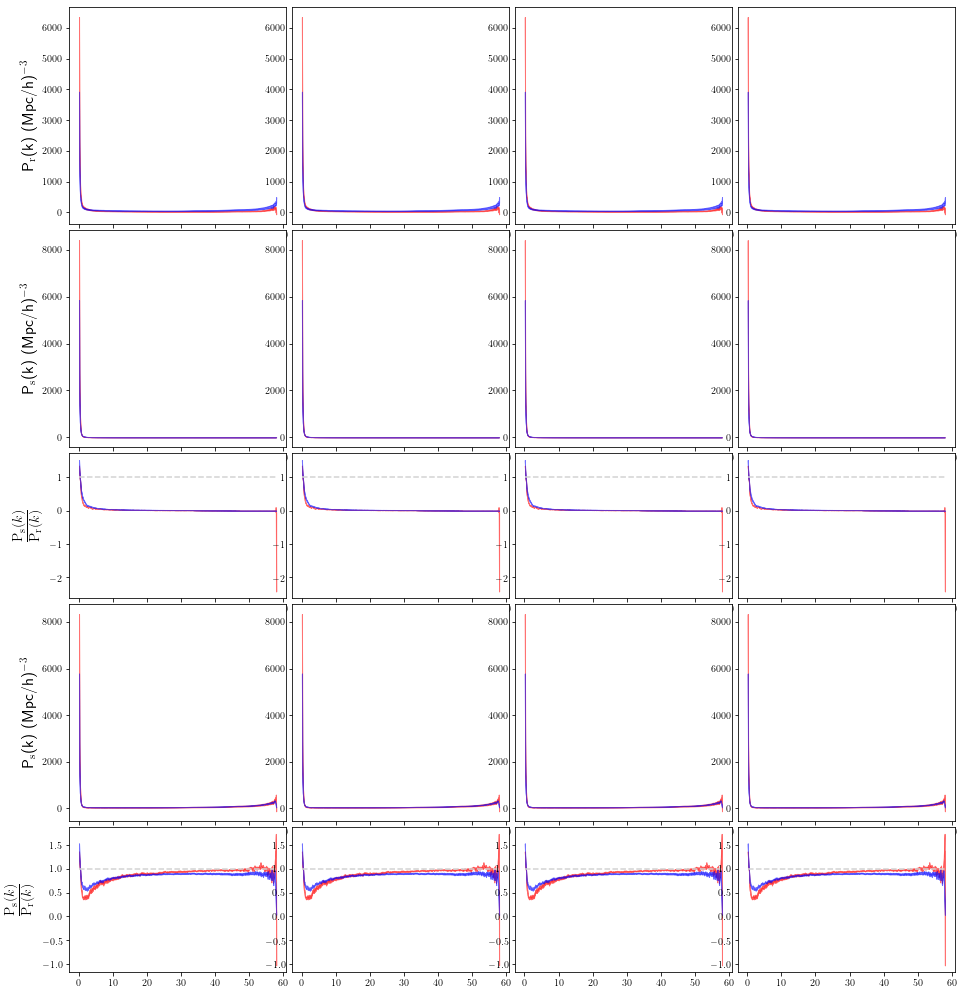

In [19]:
fig

In [20]:
# for i in range(nrows):
#     for j in range(ncols):
#         ax = panels[i][j]
#         print(i,j)
#         print(ax.get_lines())

In [21]:
dist_panels = [(2,j) for j in range(ncols)]
dist_panels = dist_panels + [(4,j) for j in range(ncols)]
flib.has_cbar_col = False
box = head['BoxSize'] /1e3 * head['Time']
mink = wavenum[0]

# axes
flib.logAxis('x')
flib.logAxis('y', panel_exceptions=dist_panels)
flib.xLimAdjustToNyquist(gridres=800, box = box, xleft=mink)
#flib.flushYAxisToData(panel_exceptions=dist_panels)
flib.flushYAxisToData()
flib.matchAxisLimits()

# ticks
flib.changeTickDirection()
flib.removeDefaultTickLabels()

# labels
rowlabels = ['Particles, Real-Space', 'Particles, Redshift-Space', 'Particle RSD', 'Galaxies, Redshift-Space', 'Galaxy RSD']
flib.addLegend((0,1))
flib.axisLabel('k (Mpc/h)$^{-1}$','x')
flib.addRowLabels(rowlabels, pos = (0.5, 0.95), va='top', ha='center')
flib.addColLabels(rslabels, in_panel=True)

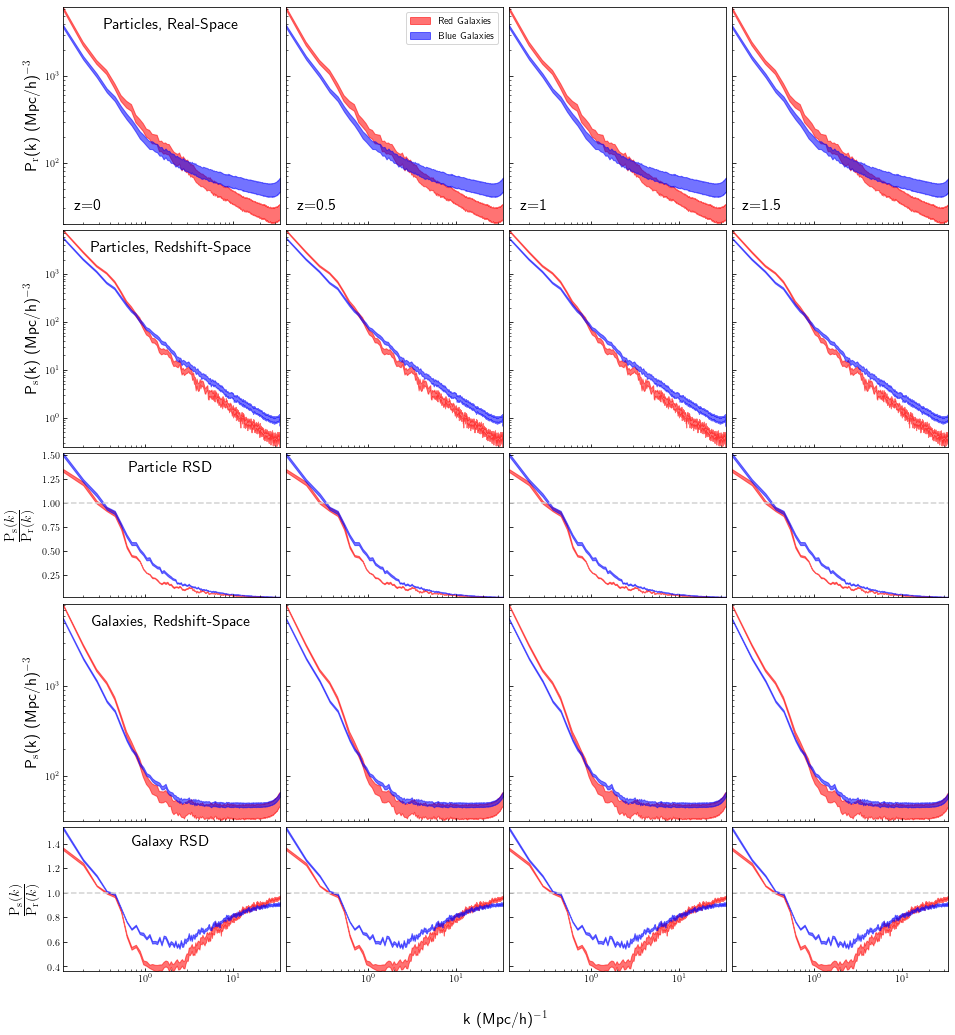

In [22]:
fig

In [23]:
fig.savefig('HIXGAL_color_with_distortion_FINAL.pdf')

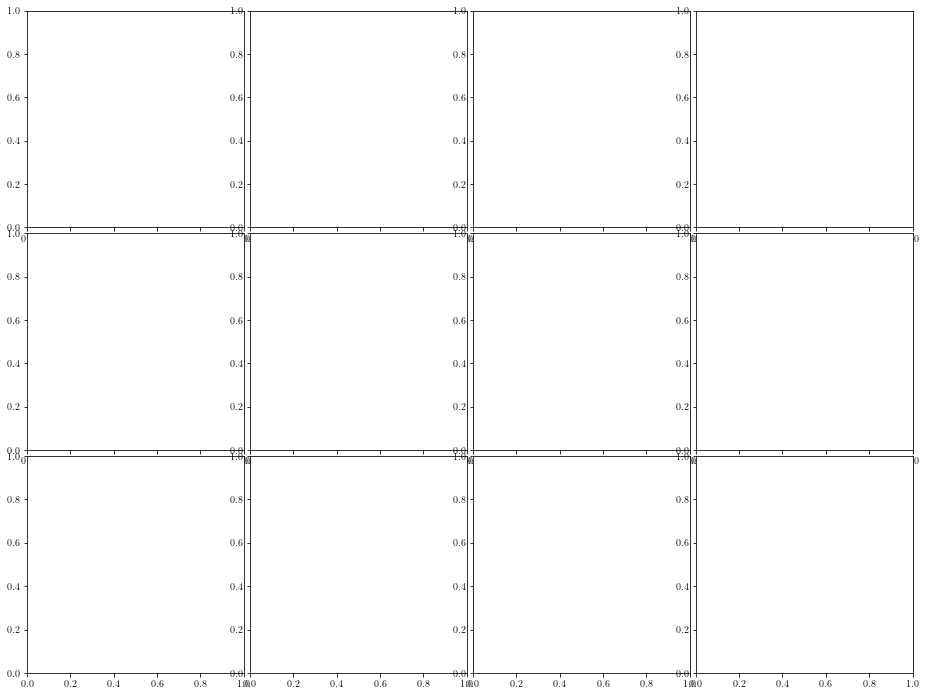

In [14]:
# Now with vn
nrows = 3
ncols = 4
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3


# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols)
plt.subplots_adjust(left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.has_cbar_panel = False
flib.figsize = [figwidth, figheight]

In [15]:
keys_for_panels = np.empty((nrows,ncols), dtype=object)

z0 = fsr['0 0 0 x'].attrs['redshift']
fieldnames = ['hiptl','hiptl','hisubhalo']
spaces = ['real', 'redshift','redshift']
# CHANGE WHEN MORE REDSHIFTS ARE CALCULATED
redshifts = [z0, z0, z0, z0]
for i in range(nrows):
    for j in range(ncols):
        props = {'fieldname':fieldnames[i], 'space':spaces[i], 'redshift':redshifts[j]}
        keys_for_panels[i,j] = get_match(props)
        if fieldnames[i] == 'hiptl':
            vnprops = copy.copy(props)
            vnprops['fieldname'] = 'vn'
            keys_for_panels[i,j].extend(get_match(vnprops))


In [16]:
for i in range(nrows):
    for j in range(ncols):
        idx = (i, j)
        keys = keys_for_panels[idx]
        
        if i == 0:
            # plot reds
            plot_pk = []
            for k in keys:
                wavenum = fsr[k]
                pk_key = k[:-1] + 'y'
                pk = fsr[pk_key]
                if 'red' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_pk.append(pk[:])
            plot_pk = np.array(plot_pk)
            flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Red Galaxies', color='red')

            # plot blues
            plot_pk = []
            for k in keys:
                wavenum = fsr[k]
                pk_key = k[:-1] + 'y'
                pk = fsr[pk_key]
                if 'blue' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_pk.append(pk[:])
            plot_pk = np.array(plot_pk)
            flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Blue Galaxies', color='blue')
        else:
            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
                real_data = get_match(props)
                rd = real_data[0]
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'red' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
            flib.plotFillPanel(idx,plot_wn, plot_dist,color='red', label='Red Galaxies')
            
            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
#                 print(props)
                real_data = get_match(props)
                rd = real_data[0]
#                 print(len(real_data))
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'blue' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
            flib.plotFillPanel(idx,plot_wn, plot_dist,color='blue', label='Blue Galaxies')




In [17]:
pe1 = [(1,i) for i in range(4)]
pe1 += [(2,i) for i in range(4)]
flib.logAxis('x')
flib.logAxis('y',panel_exceptions=pe1)
box = head['BoxSize'] /1e3 * head['Time']
mink = wavenum[0]
flib.changeTickDirection()
flib.xLimAdjustToNyquist(gridres=800, box=box, xleft=mink)

flib.flushYAxisToData()
flib.removeDefaultTickLabels()


flib.addColLabels(rslabels, in_panel=True)
flib.addLegend((0,1))
flib.matchAxisLimits()

flib.has_cbar_col = False
flib.axisLabel('k (Mpc/h)$^{-1}$','x')
flib.axisLabel('P$^r$(k) (Mpc/h)$^{-3}$', 'y', pos=[xborder[0]/3/figwidth, 1-((panel_length/2+yborder[0])/figheight)],
              fsize=12)
flib.addRowLabels(fnvnshort, pos = (0.5, 0.95), va='top', ha='center')

flib.axisLabel('P$^s$(k) / P$^r$(k)', 'y', pos=[xborder[0]/3/figwidth, (panel_length + yborder[0])/figheight])

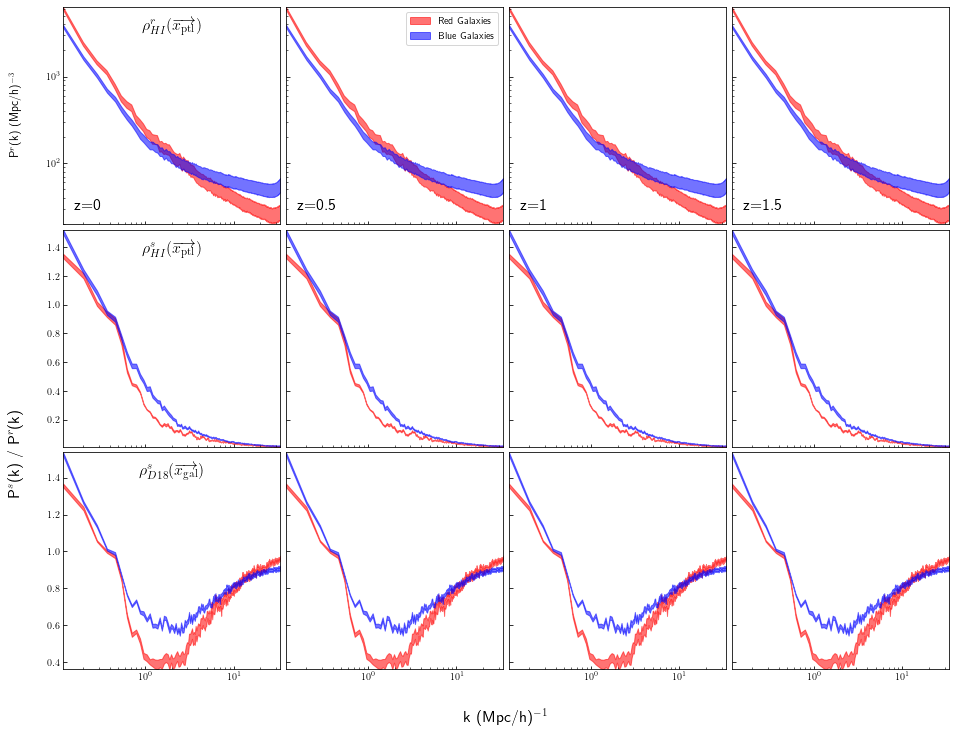

In [18]:
fig

In [19]:
for i in [1,2]:
    for j in range(ncols):
        ax = panels[i][j]
        xmin, xmax = ax.get_xlim()
        ax.plot([xmin, xmax], [1,1], color='lightgray', linestyle='--')

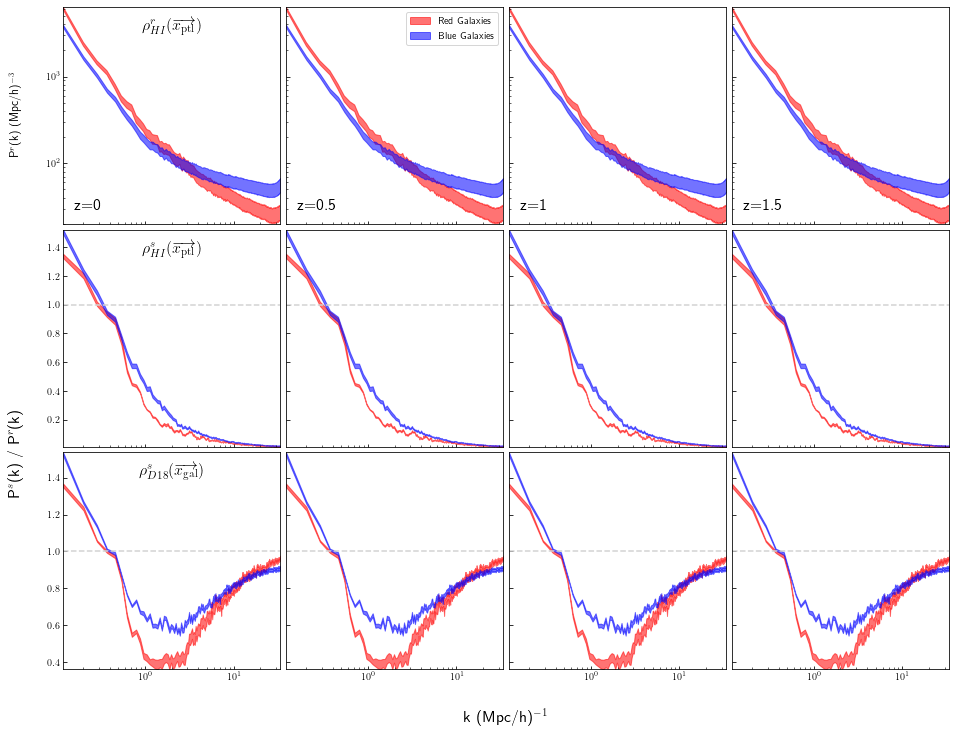

In [20]:
fig

In [21]:
fig.savefig('HIXGAL_fieldnameR_redshiftC_color_with_distortion.png')

4
4
4


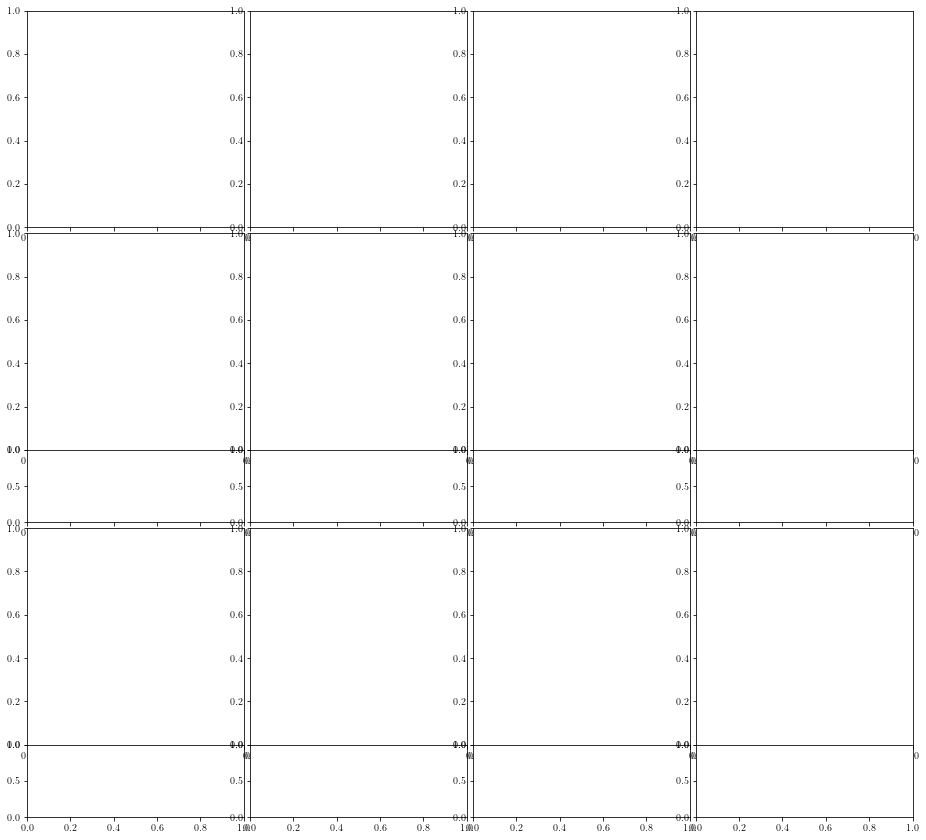

In [38]:
# first figure
nrows = 3
ncols = 4
ndist = 2
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3
dist_panel_length = 1

# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + dist_panel_length * ndist + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols, left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight, height_ratios=[3,4,4])

dist_rows = [1,2]
row_subgs = np.empty((nrows,ncols), dtype=object)
for i in dist_rows:
    for j in range(ncols):
        gs0 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[i,j], hspace=0, height_ratios=[3,1])
        row_subgs[i,j] = gs0

# making panels list
panels = []
dist_panels = []
for i in range(nrows):
    col_panels = []
    cdp = []
    for j in range(ncols):
        if i == 0:
            col_panels.append(fig.add_subplot(gs[i,j]))
        else:
            col_panels.append(fig.add_subplot(row_subgs[i,j][0]))
            cdp.append(fig.add_subplot(row_subgs[i,j][1]))
    panels.append(col_panels)
    dist_panels.append(cdp)
    print(len(col_panels))

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.has_cbar_col = False
flib.figsize = [figwidth, figheight]

In [39]:
keys_for_panels = np.empty((nrows,ncols), dtype=object)

z0 = fsr['0 0 0 x'].attrs['redshift']
fieldnames = ['hiptl','hiptl','hisubhalo']
spaces = ['real', 'redshift','redshift']
# CHANGE WHEN MORE REDSHIFTS ARE CALCULATED
redshifts = [z0, z0, z0, z0]
for i in range(nrows):
    for j in range(ncols):
        props = {'fieldname':fieldnames[i], 'space':spaces[i], 'redshift':redshifts[j]}
        keys_for_panels[i,j] = get_match(props)
        if fieldnames[i] == 'hiptl':
            vnprops = copy.copy(props)
            vnprops['fieldname'] = 'vn'
            keys_for_panels[i,j].extend(get_match(vnprops))


In [40]:
print(len(panels[0]))
len(panels)
print(len(dist_panels))
print(len(dist_panels[1]))

4
3
4


In [41]:
for i in range(nrows):
    for j in range(ncols):
        idx = (i, j)
        keys = keys_for_panels[idx]

        # plot reds
        plot_pk = []
        for k in keys:
            wavenum = fsr[k]
            pk_key = k[:-1] + 'y'
            pk = fsr[pk_key]
            if 'red' in wavenum.attrs['color']:
                plot_wn = wavenum[:]
                plot_pk.append(pk[:])
        plot_pk = np.array(plot_pk)
        flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Red Galaxies', color='red')

        # plot blues
        plot_pk = []
        for k in keys:
            wavenum = fsr[k]
            pk_key = k[:-1] + 'y'
            pk = fsr[pk_key]
            if 'blue' in wavenum.attrs['color']:
                plot_wn = wavenum[:]
                plot_pk.append(pk[:])
        plot_pk = np.array(plot_pk)
        flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'Blue Galaxies', color='blue')

#         # plot all
#         plot_pk = []
#         for k in keys:
#             wavenum = fsr[k]
#             pk_key = k[:-1] + 'y'
#             pk = fsr[pk_key]
#             if 'resolved' in wavenum.attrs['color']:
#                 plot_wn = wavenum[:]
#                 plot_pk.append(pk[:])
#         plot_pk = np.array(plot_pk)
#         flib.plotFillPanel(idx, plot_wn, plot_pk, label = 'All Galaxies', color='gray')


In [42]:

for i in range(nrows):
    for j in range(ncols):
        if not i == 0:
            ax = dist_panels[i][j]
            idx = (i, j)
            keys = keys_for_panels[idx]


            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
                real_data = get_match(props)
    #                 print(len(real_data))
                rd = real_data[0]
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'red' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
            mn = np.min(plot_dist, axis=0)
            mx = np.max(plot_dist, axis=0)
            ax.fill_between(plot_wn, mn, mx, color='red')
            ax.plot([plot_wn[0], plot_wn[1]],[1,1], color='lightgray', linestyle='--')
            
            plot_dist = []
            for k in keys:
                wavenum = fsr[k]
                props = dict(fsr[k].attrs)
                props['space'] = 'real'
                props['fieldname'] = props['fieldname'][0]
    #                 print(props)
                real_data = get_match(props)
                rd = real_data[0]
    #                 print(len(real_data))
                pk_key = k[:-1] + 'y'
                rspk = fsr[pk_key]
                rlpk = fsr[rd[:-1] + 'y']
                if 'blue' in wavenum.attrs['color']:
                    plot_wn = wavenum[:]
                    plot_dist.append(rspk[:]/rlpk[:])
            plot_dist = np.array(plot_dist)
            mn = np.min(plot_dist, axis=0)
            mx = np.max(plot_dist, axis=0)
            ax.fill_between(plot_wn, mn, mx, color='red')


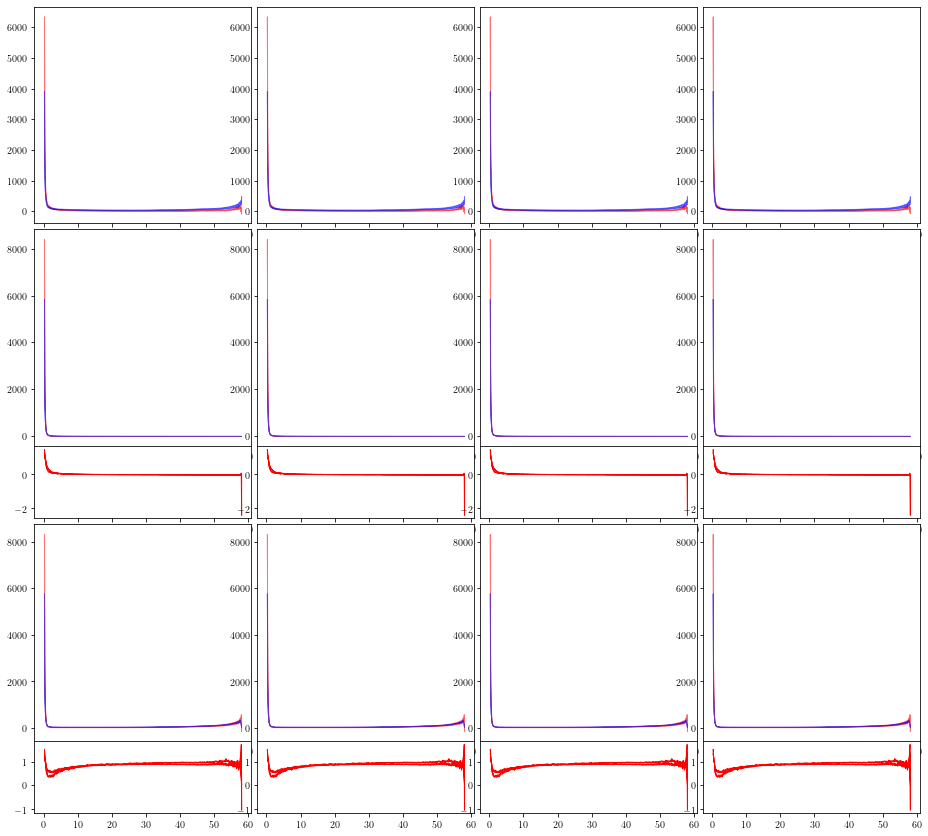

In [43]:
fig

In [44]:
flib.logAxis('both')
box = head['BoxSize'] /1e3 * head['Time']
mink = wavenum[0]

flib.xLimAdjustToNyquist(gridres=800, box=box, xleft=mink)
flib.flushYAxisToData()
flib.removeDefaultTickLabels()

flib.addRowLabels(fnvnshort, pos = (0.5,0.95), va = 'top', ha='center')

flib.addColLabels(rslabels, in_panel = True, row_idx = 0)
flib.changeTickDirection()
flib.defaultAxesLabels()
flib.matchAxisLimits()
flib.addLegend((0,1))

In [ ]:
for i in range(len(dist_panels)):
    for j in range(len(dist_panels[i])):
        ax = dist_panels[i][j]
        
        ax.tick_params()

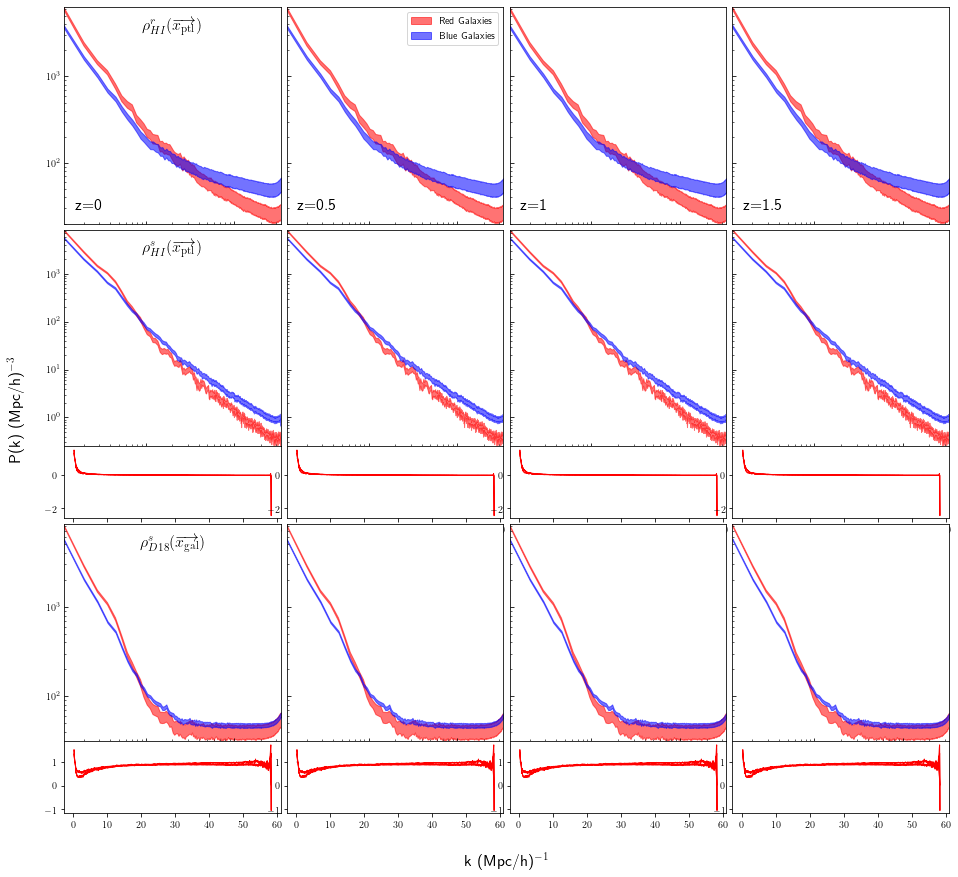

In [45]:
fig